In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import deque

## Normal Form Games

Prisoner's Dilemma (PD)
\begin{equation}
A, B
=\begin{pmatrix}
A_{11},B_{11} & A_{12},B_{12} \\
A_{21},B_{21} & A_{22},B_{22}
\end{pmatrix}
=\begin{pmatrix}
3,3 & 0,5 \\
5,0 & 1,1
\end{pmatrix}
\end{equation}

Stag Hunt (SH)
\begin{equation}
\begin{pmatrix}
4,4 & 1,3 \\
3,1 & 3,3
\end{pmatrix}
\end{equation}

Pure Coordination (PC)
\begin{equation}
\begin{pmatrix}
1,1 & 0,0 \\
0,0 & 1,1
\end{pmatrix}
\end{equation}

Matching Pennies (MP)
\begin{equation}
\begin{pmatrix}
1,0 & 0,1 \\
0,1 & 1,0
\end{pmatrix}
\end{equation}

Battle of the Sexes (BS)
\begin{equation}
\begin{pmatrix}
2,1 & 0,0 \\
0,0 & 1,2
\end{pmatrix}
\end{equation}

In [2]:
PayoffD = {}

A = np.array([[3, 0], [5, 1]])
B = A.T
PayoffD['PD'] = (A, B)

A = np.array([[4, 1], [3, 3]])
B = A.T
PayoffD['SH'] = (A, B)

A = np.array([[1, 0], [0, 1]])
B = A.T
PayoffD['PC'] = (A, B)

A = np.array([[1, 0], [0, 1]])
B = np.array([[0, 1], [1, 0]])
PayoffD['MP'] = (A, B)

A = np.array([[2, 0], [0, 1]])
B = np.array([[1, 0], [0, 2]])
PayoffD['BS'] = (A, B)

## Plotting functions

In [3]:
def configSubplot(fig, gs, subplotParasDL): # configure the sub-plots
    for i, subplotParasD in enumerate(subplotParasDL):
        ax1 = fig.add_subplot(gs[i])
        ax1.set_aspect('equal')
        ax1.set_title(subplotParasD['title'])
        ax1.set_xlabel(r'$x_1$')
        ax1.set_ylabel(r'$y_1$')

### Vector Field

In [4]:
def plotVFmain(fig, gameNameL, fEDL, ParasDL): # loop through the settings and plot the vector field
    xA = np.linspace(0.05, 0.95, 10)
    yA = np.linspace(0.05, 0.95, 10)
    X, Y = np.meshgrid(xA, yA)

    for i, (gameName, fED, ParasD) in enumerate(zip(gameNameL, fEDL, ParasDL)): # for each setting
        A = PayoffD[gameName][0]
        B = PayoffD[gameName][1]

        ax1 = fig.get_axes()[i] # get the sub-plot

        U1, V1 = calVF1(ax1, xA, yA, X, Y, A, B, fED, ParasD) # calculate (dx1, dy1) in (X, Y)

        M1 = np.hypot(U1, V1) # the vector field
        quiver1 = ax1.quiver(X, Y, U1, V1, M1) # plot the vector field graph

In [5]:
def calVF1(ax1, xA, yA, X, Y, A, B, fED, ParasD): # calculate (dx1, dy1) in (X, Y)
    U1, V1 = np.zeros_like(X), np.zeros_like(Y)

    for i, y1 in enumerate(yA):
        for j, x1 in enumerate(xA):
            xv = np.array([x1, 1-x1])
            yv = np.array([y1, 1-y1])

            dx1, dy1 = fED(xv, yv, A, B, ParasD) # evaluate dx1, dy1

            U1[i][j] = dx1
            V1[i][j] = dy1
    return U1, V1

### Agent-based simulations

In [6]:
# loop through the settings and plot the policy over time through agent-based simulations
def plotABSmain(fig, gameNameL, fSimL, fUpdateL, ParasDL, v10LL, v20LL, fGetPolicyL=[None]*99):
    # for each setting
    for i, (gameName, fSim, fUpdate, ParasD, v10L, v20L, fGetPolicy) in enumerate(zip(gameNameL, fSimL, fUpdateL, ParasDL, v10LL, v20LL, fGetPolicyL)):
        A = PayoffD[gameName][0]
        B = PayoffD[gameName][1]

        ax1 = fig.get_axes()[i] # get the sub-plot
        for j, (v10, v20) in enumerate(zip(v10L, v20L)): # for each initial value
            piT, phiT = fSim(A, B, v10, v20, fUpdate, ParasD, fGetPolicy) # calculate the policy over time (pi(t), phi(t))
            ax1.plot(piT[:, 0], phiT[:, 0]) # line plot of the policy (pi1(t), phi1(t))

In [7]:
# Policy-based learning, starting with the initial policies (pi0, phi0), we simulate the gamelay and learning for Niter=500 time steps,
                        # the agents' policies over time are recorded and the average policies over Nsim=100 simulations are return.
def ABSpolicy1(A, B, pi0, phi0, fUpdate, ParasD, fGetPolicyL, Nsim=100, Niter=500):
    piT = np.zeros((Niter+1, 2))
    phiT = np.zeros((Niter+1, 2))

    for sim in range(Nsim):
        pi = np.array(pi0) # initial policy
        phi = np.array(phi0)
        piT[0] += pi
        phiT[0] += phi
        for t in range(1, Niter+1):
            # gameplay
            a1 = np.random.choice(2, p=pi)
            a2 = np.random.choice(2, p=phi)
            r1 = A[a1, a2]
            r2 = B[a1, a2]

            # policy update
            pi = fUpdate(pi, a1, r1, ParasD)
            phi = fUpdate(phi, a2, r2, ParasD)

            # recording
            piT[t] += pi
            phiT[t] += phi
    # averaging
    piT /= Nsim
    phiT /= Nsim

    return piT, phiT

In [8]:
# Value-based learning
def ABSvalue1(A, B, Q0, R0, fUpdate, ParasD, fGetPolicy, Nsim=5, Niter=10000): # policy = softmax(Q)
    piT = np.zeros((Niter+1, 2))
    phiT = np.zeros((Niter+1, 2))

    for sim in range(Nsim):
        Q = np.array(Q0) # initial Q-values
        R = np.array(R0)
        pi = fGetPolicy(Q, ParasD) # softmax function
        phi = fGetPolicy(R, ParasD)

        piT[0] += pi
        phiT[0] += phi
        for t in range(1, Niter+1):
            # gameplay
            a1 = np.random.choice(2, p=pi)
            a2 = np.random.choice(2, p=phi)
            r1 = A[a1, a2]
            r2 = B[a1, a2]

            # Q-value update
            Q = fUpdate(Q, pi, a1, r1, ParasD)
            R = fUpdate(R, phi, a2, r2, ParasD)
            pi = fGetPolicy(Q, ParasD)
            phi = fGetPolicy(R, ParasD)

            # recording
            piT[t] += pi
            phiT[t] += phi
    # averaging
    piT /= Nsim
    phiT /= Nsim

    return piT, phiT

In [9]:
# Value-based 'Lenient' learning: r(a) = max{r(a)_1, ..., r(a)_K}
def ABSvalue1Lenient(A, B, Q0, R0, fUpdate, ParasD, fGetPolicy, Nsim=5, Niter=10000): # policy = softmax(Q)
    tau = ParasD['tau']
    kappa = ParasD['kappa']
    piT = np.zeros((Niter+1, 2))
    phiT = np.zeros((Niter+1, 2))

    for sim in range(Nsim):
        r1HD = {}
        r1HD[0] = deque([], maxlen=kappa)
        r1HD[1] = deque([], maxlen=kappa)
        r2HD = {}
        r2HD[0] = deque([], maxlen=kappa)
        r2HD[1] = deque([], maxlen=kappa)

        Q = np.array(Q0) # initial Q-values
        R = np.array(R0)
        pi = fGetPolicy(Q, ParasD) # softmax function
        phi = fGetPolicy(R, ParasD)
        piT[0] += pi
        phiT[0] += phi
        for t in range(1, Niter+1):
            # gameplay
            a1 = np.random.choice(2, p=pi)
            a2 = np.random.choice(2, p=phi)
            r1 = A[a1, a2]
            r2 = B[a1, a2]
            r1HD[a1].append(r1)
            r2HD[a2].append(r2)

            # Q-value update
            Q = fUpdate(Q, pi, a1, max(r1HD[a1]), ParasD)
            R = fUpdate(R, phi, a2, max(r2HD[a2]), ParasD)
            pi = fGetPolicy(Q, ParasD)
            phi = fGetPolicy(R, ParasD)

            # recording
            piT[t] += pi
            phiT[t] += phi
    # averaging
    piT /= Nsim
    phiT /= Nsim

    return piT, phiT

## Cross Learning (CL)
Let $\pi=[\pi(1), ..., \pi(|A|)]^\top$ be the policy of an agent, after performing action $a_j$ and receiving a reward $r$, the agent update its policy with the following equation:
\begin{equation}
  \tag{1}
  \pi(i) \leftarrow \pi(i) + \begin{cases} r-\pi(i)r & \text{if }i=j \\ -\pi(i)r & \text{o/w} \end{cases}
\end{equation}
where $0\le r\le 1$.

**Note:** In practice, if the payoffs of the NFG are positive but larger than $1$, we can multiply the reward by a learning rate $\alpha$ to make the learning stable.

### Replicator Dynamics as the Continuous Time Limit of Cross Learning
Consider $2$ agents learning to play a NFG under Cross Learning, let $\pi$, $\phi$ be their current policies, and x and y the corresponding representative populations. Then the expected change of their policies are evaluated as
\begin{align}
\tag{2a}
x_i' &= E[\frac{d\pi(i)}{dt}] = x_i [e_i^\top A y - x^\top A y] \\
\tag{2b}
y_i' &= E[\frac{d\phi(i)}{dt}] = y_i [x^\top B e_i - x^\top B y]
\end{align}
where $e_i=[0...1...0]^\top$ is an one-hot vector with the $i^{th}$ element equal 1.

**Task 0:** implement the functions to evaluate the CL update (1) and the CL dynamics (2).

In [10]:
def CLupdate(policy, a, r, ParasD):
    alpha = ParasD['alpha']

    ##########################################################################
    # TODO: calculate and return the new policy; see equation (1)
    e_a = np.eye(2)[a]
    policyNew = policy + alpha * r * (e_a-policy)
    return policyNew

In [11]:
def CLdynamics(xv, yv, A, B, ParasD={}): # Replicator Dynamics
    ##########################################################################
    # TODO: calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (2)
    e1 = np.array([1, 0])
    dx1 = xv[0] * (e1 @ A @ yv - xv @ A @ yv)
    dy1 = yv[0] * (xv @ B @ e1 - xv @ B @ yv)
    return dx1, dy1

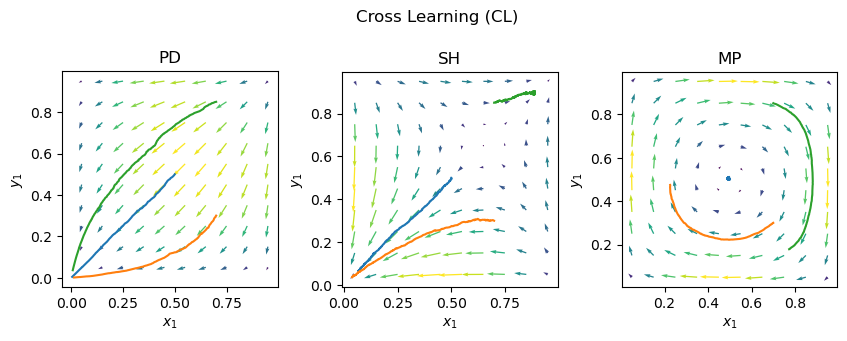

In [12]:
fig = plt.figure(figsize=(10, 3.5))
gs = GridSpec(1, 3, wspace=0.3, hspace=0)
plt.suptitle('Cross Learning (CL)')

subplotParasDL = [{'title': 'PD'}, {'title': 'SH'}, {'title': 'MP'}]
configSubplot(fig, gs, subplotParasDL)

# plot the dynamics and policies paths on 3 games
gameNameL = ['PD', 'SH', 'MP']

# Learning Dynamics
fEDL = [CLdynamics, CLdynamics, CLdynamics] # Replicator Dynamics
ParasDL = [{'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.01}] # learning rate

plotVFmain(fig, gameNameL, fEDL, ParasDL)

# Simulations
fSimL = [ABSpolicy1] * len(gameNameL)
fUpdateL = [CLupdate] * len(gameNameL)
pi0LL =  [ [(0.5, 0.5), (0.7, 0.3), (0.7, 0.3)] ] * len(gameNameL) #initial policy for first player
phi0LL = [ [(0.5, 0.5), (0.3, 0.7), (0.85, 0.15)] ] * len(gameNameL) #initial policy for second player

plotABSmain(fig, gameNameL, fSimL, fUpdateL, ParasDL, pi0LL, phi0LL)

plt.show()

## Frequency-adjusted Q-learning (FAQ)
\begin{align}
  \tag{3}
  Q(j) &\leftarrow Q(j) + \frac{1}{\pi(j)}\alpha[r+\gamma\max_k Q(k) - Q(j)] \\
  \tag{4}
  \pi(i) &= \frac{e^{Q(i)/\tau}}{\sum_k e^{Q(k)/\tau}}
\end{align}
where only the Q-value of the selected action $a_j$ is updated.

**Note:** In practice, the term $\frac{1}{\pi(i)}$ is replaced by $\min\{\frac{\alpha}{\pi(i)}, 1\}$, to avoid divergent behaviour.

### Learning Dynamics
\begin{align}
\tag{5a}
x_i' &= E[\frac{d\pi(i)}{dt}] &= \frac{\alpha x_i}{\tau} [e_i^\top A y - x^\top A y] -\alpha x_i[\log x_i - \sum_k x_k \log x_k]\\
\tag{5b}
y_i' &= E[\frac{d\phi(i)}{dt}] &= \frac{\alpha y_i}{\tau} [x^\top B e_i - x^\top B y] -\alpha y_i[\log y_i - \sum_k y_k \log y_k]
\end{align}

**Task 1:** implement the functions to evaluate the FAQ update (3), the Softmax policy (4), and the FAQ dynamics (5).

In [13]:
def FAQupdate(Qv, pv, a, r, ParasD):
    alpha = ParasD['alpha']
    gamma = ParasD['gamma']

    ##########################################################################
    # TODO: calculate and return the new Q-vector; see equation (3)
    maxQ = np.amax(Qv)
    Qv[a] = Qv[a] + np.min((alpha/pv[a], 1)) * alpha * (r+gamma*maxQ - Qv[a])
    return Qv

In [14]:
def FAQgetPolicy(Qv, ParasD):
    tau = ParasD['tau']

    ##########################################################################
    # TODO: calculate and return the policy; see equation (4)
    pi = np.exp(Qv/tau) / np.sum(np.exp(Qv/tau))
    return pi

In [15]:
def FAQdynamics(xv, yv, A, B, ParasD):
    alpha = ParasD['alpha']
    tau = ParasD['tau']

    ##########################################################################
    # TODO: calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (5)
    e1 = np.array([1, 0])
    dx1 = alpha*xv[0]/tau * (e1 @ A @ yv - xv @ A @ yv) \
            - alpha*xv[0] * (np.log(xv[0]) - np.sum(xv*np.log(xv)))
    dy1 = alpha*yv[0]/tau * (xv @ B @ e1 - xv @ B @ yv) \
            - alpha*yv[0] * (np.log(yv[0]) - np.sum(yv*np.log(yv)))
    return dx1, dy1

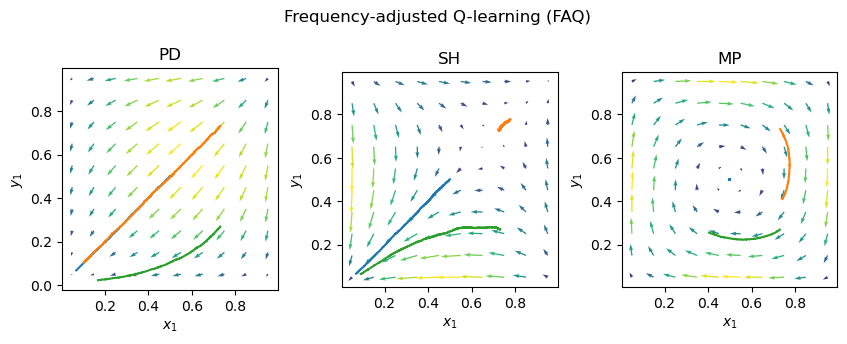

In [16]:
fig = plt.figure(figsize=(10, 3.5))
gs = GridSpec(1, 3, wspace=0.3, hspace=0)
plt.suptitle('Frequency-adjusted Q-learning (FAQ)')

subplotParasDL = [{'title': 'PD'}, {'title': 'SH'}, {'title': 'MP'}]
configSubplot(fig, gs, subplotParasDL)

# plot the dynamics and policies paths on 3 games
gameNameL = ['PD', 'SH', 'MP']

# Learning Dynamics
fEDL = [FAQdynamics] * len(gameNameL)
ParasDL = [{'alpha': 0.005, 'tau': 0.1, 'gamma': 0.9}] * len(gameNameL)

plotVFmain(fig, gameNameL, fEDL, ParasDL)

# Simulations
fSimL = [ABSvalue1] * len(gameNameL)
fUpdateL = [FAQupdate] * len(gameNameL)
fGetPolicyL = [FAQgetPolicy] * len(gameNameL)
Q0LL = [ [(2.5, 2.5), (2.6, 2.5), (2.6, 2.5)] ] * len(gameNameL)
R0LL = [ [(2.5, 2.5), (2.6, 2.5), (2.5, 2.6)] ] * len(gameNameL)

plotABSmain(fig, gameNameL, fSimL, fUpdateL, ParasDL, Q0LL, R0LL, fGetPolicyL)

plt.show()

## Lenient FAQ (LFAQ)
\begin{equation}
  \tag{6}
  Q(j) \leftarrow Q(j) + \frac{1}{\pi(j)}\alpha[r+\max_k Q(k) - Q(j)]
\end{equation}
where $r=\max\{r_1, ..., r_\kappa\}$ is the maximum reward the agent received over the last $\kappa$ times when action $a_j$ is performed.

### Learning Dynamics
\begin{align}
\tag{7a}
x_i' &= \frac{\alpha x_i}{\tau} [u_i - x^\top u] -\alpha x_i[\log x_i - \sum_k x_k \log x_k]\\
\tag{7b}
y_i' &= \frac{\alpha y_i}{\tau} [v_i - w^\top y] -\alpha y_i[\log y_i - \sum_k y_k \log y_k]
\end{align}
where
\begin{align}
u_i &= \sum_j \frac{A_{ij}y_j[(\sum_{k:A_{ik}\leq A_{ij}} y_k)^\kappa - (\sum_{k:A_{ik}<A_{ij}} y_k)^\kappa]}{\sum_{k:A_{ik}=A_{ij}} y_k} \\
w_i &= \sum_j \frac{B_{ji}x_j[(\sum_{k:B_{ki}\leq B_{ji}} x_k)^\kappa - (\sum_{k:B_{ki}<B_{ji}} x_k)^\kappa]}{\sum_{k:B_{ki}=B_{ji}} x_k}
\end{align}

In [17]:
def LFAQdynamics(xv, yv, A, B, ParasD): # 2-action
    alpha = ParasD['alpha']
    tau = ParasD['tau']
    kappa = ParasD['kappa']

    # calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (7)
    uv = np.zeros(2)
    wv = np.zeros(2)
    for i in range(2):
        for j in range(2):
            sum1 = np.sum(yv*(A[i,:]<=A[i,j]))
            sum2 = np.sum(yv*(A[i,:]<A[i,j]))
            sum3 = np.sum(yv*(A[i,:]==A[i,j]))
            uv[i] += A[i,j] *yv[j] *(sum1**kappa-sum2**kappa) /sum3

            sum1 = np.sum(xv*(B[:,i]<=B[j,i]))
            sum2 = np.sum(xv*(B[:,i]<B[j,i]))
            sum3 = np.sum(xv*(B[:,i]==B[j,i]))
            wv[i] += B[j,i] *xv[j] *(sum1**kappa-sum2**kappa) /sum3

    e1 = np.array([1, 0])
    dx1 = alpha*xv[0]/tau * (e1 @ uv - xv @ uv) \
            - alpha*xv[0] * (np.log(xv[0]) - np.sum(xv*np.log(xv)))
    dy1 = alpha*yv[0]/tau * (wv @ e1 - wv @ yv) \
            - alpha*yv[0] * (np.log(yv[0]) - np.sum(yv*np.log(yv)))

    return dx1, dy1

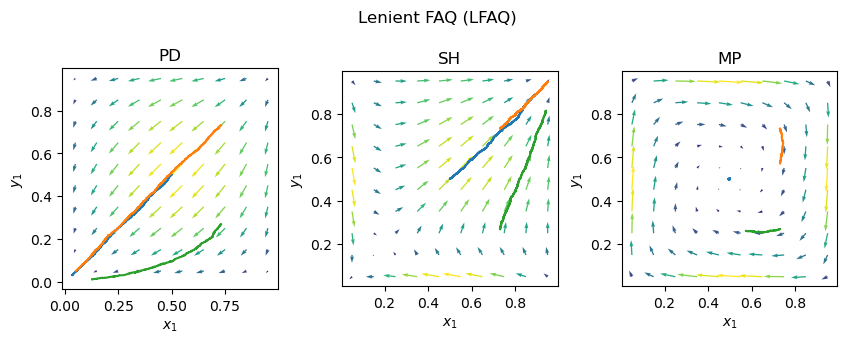

In [18]:
fig = plt.figure(figsize=(10, 3.5))
gs = GridSpec(1, 3, wspace=0.3, hspace=0)
plt.suptitle('Lenient FAQ (LFAQ)')

subplotParasDL = [{'title': 'PD'}, {'title': 'SH'}, {'title': 'MP'}]
configSubplot(fig, gs, subplotParasDL)

# plot the dynamics and policies paths on 3 games
gameNameL = ['PD', 'SH', 'MP']

# Learning Dynamics
fEDL = [LFAQdynamics] * len(gameNameL)
ParasDL = [{'alpha': 0.005, 'tau': 0.1, 'gamma': 0.9, 'kappa': 5}] * len(gameNameL)

plotVFmain(fig, gameNameL, fEDL, ParasDL)

# Simulations
fSimL = [ABSvalue1Lenient] * len(gameNameL)
fUpdateL = [FAQupdate] * len(gameNameL)
fGetPolicyL = [FAQgetPolicy] * len(gameNameL)
Q0LL = [ [(2.5, 2.5), (2.6, 2.5), (2.6, 2.5)] ] * len(gameNameL)
R0LL = [ [(2.5, 2.5), (2.6, 2.5), (2.5, 2.6)] ] * len(gameNameL)

plotABSmain(fig, gameNameL, fSimL, fUpdateL, ParasDL, Q0LL, R0LL, fGetPolicyL)

plt.show()

## Gradient ascent algorithms (in 2-player 2-action setting)

### Infinitesimal gradient ascent (IGA)
\begin{align}
\triangle x_i &\leftarrow \alpha \frac{\partial V(x)}{\partial x_i} \\
x &\leftarrow \text{projection}(x+\triangle x)
\end{align}
#### Learning Dynamics
\begin{align}
\tag{8a}
x_1' &= \alpha [e_1^\top A y - e_2^\top A y] \\
\tag{8b}
y_1' &= \alpha [x^\top B e_1 - x^\top B e_2]
\end{align}

### Win or learn fast (IGA-WoLF)
\begin{align}
\triangle x_i &\leftarrow \frac{\partial V(x)}{\partial x_i} \cdot \begin{cases} \alpha_{\min} & \text{if } V(x)> V(x^*) \\ \alpha_{\max} & \text{o/w} \end{cases} \\
x &\leftarrow \text{projection}(x+\triangle x)
\end{align}
where $V(x^*)$ is the payoff at an arbitrary Nash equilibrium.
#### Learning Dynamics
\begin{align}
\tag{9a}
x_1' &= [e_1^\top A y - e_2^\top A y] \cdot \begin{cases} \alpha_{\min} & \text{if } V(x)> V(x^*) \\ \alpha_{\max} & \text{o/w} \end{cases} \\
\tag{9b}
y_1' &= [x^\top B e_1 - x^\top B e_2] \cdot \begin{cases} \alpha_{\min} & \text{if } V(y)> V(y^*) \\ \alpha_{\max} & \text{o/w} \end{cases}
\end{align}

### Weighted policy learner (WPL)
\begin{align}
\triangle x_i &\leftarrow \frac{\partial V(x)}{\partial x_i} \cdot \begin{cases} x_i & \text{if } \frac{\partial V(x)}{\partial x_i}<0 \\ 1-x_i & \text{o/w} \end{cases} \\
x &\leftarrow \text{projection}(x+\triangle x)
\end{align}
#### Learning Dynamics
\begin{align}
\tag{10a}
x_1' &= \alpha [e_1^\top A y - e_2^\top A y] \cdot \begin{cases} x_1 & \text{if } \eth_x<0 \\ 1-x_1 & \text{o/w} \end{cases} \\
\tag{10b}
y_1' &= \alpha [x^\top B e_1 - x^\top B e_2] \cdot \begin{cases} y_1 & \text{if } \eth_y<0 \\ 1-y_1 & \text{o/w} \end{cases}
\end{align}
where $\eth_x = \frac{\partial V(x)}{\partial x_1} = e_1^\top A y - e_2^\top A y$.

**Task 2:** implement the function to evaluate the learning dynamics for IGA (8).

In [19]:
def IGAdynamics(xv, yv, A, B, ParasD):
    alpha = ParasD['alpha']

    ##########################################################################
    # TODO: calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (8)
    e1 = np.array([1, 0])
    e2 = np.array([0, 1])
    dx1 = alpha * (e1 @ A @ yv - e2 @ A @ yv)
    dy1 = alpha * (xv @ B @ e1 - xv @ B @ e2)
    return dx1, dy1

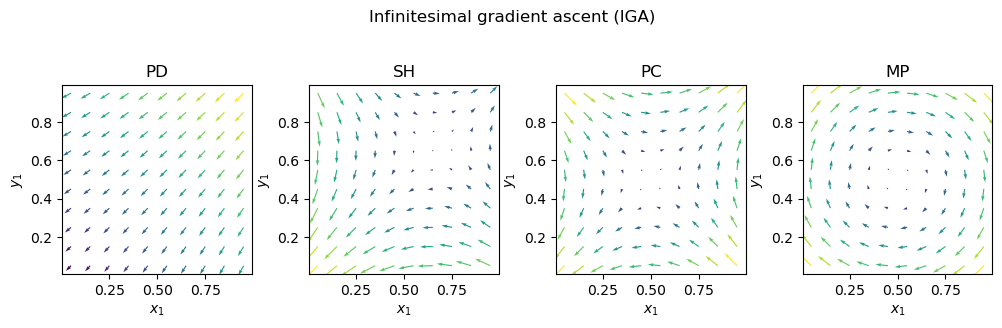

In [20]:
fig = plt.figure(figsize=(12, 3.5))
gs = GridSpec(1, 4, wspace=0.3, hspace=0)
plt.suptitle('Infinitesimal gradient ascent (IGA)')

subplotParasDL = [{'title': 'PD'}, {'title': 'SH'}, {'title': 'PC'}, {'title': 'MP'}]
configSubplot(fig, gs, subplotParasDL)

# plot the dynamics on 4 games
gameNameL = ['PD', 'SH', 'PC', 'MP']

# Learning Dynamics
fEDL = [IGAdynamics] * len(gameNameL)
ParasDL = [{'alpha': 0.1}] * len(gameNameL)

plotVFmain(fig, gameNameL, fEDL, ParasDL)

plt.show()

In [21]:
def WoLFdynamics(xv, yv, A, B, ParasD):
    alpha_min = ParasD['alpha_min']
    alpha_max = ParasD['alpha_max']
    VxStar = ParasD['VxStar']
    VyStar = ParasD['VyStar']

    # calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (9)
    Vx = xv @ A @ yv
    Vy = xv @ B @ yv
    alpha_x = alpha_min if Vx > VxStar else alpha_max
    alpha_y = alpha_min if Vy > VyStar else alpha_max

    e1 = np.array([1, 0])
    e2 = np.array([0, 1])
    dx1 = alpha_x * (e1 @ A @ yv - e2 @ A @ yv)
    dy1 = alpha_y * (xv @ B @ e1 - xv @ B @ e2)
    return dx1, dy1

In [22]:
def WPLdynamics(xv, yv, A, B, ParasD):
    alpha = ParasD['alpha']

    # calculate and return the dynamics of the first action for both players (dx1, dy1); see equation (10)
    e1 = np.array([1, 0])
    e2 = np.array([0, 1])

    eth_x = (e1 @ A @ yv - e2 @ A @ yv)
    eth_y = (xv @ B @ e1 - xv @ B @ e2)
    m_x = xv[0] if eth_x < 0 else xv[1]
    m_y = yv[0] if eth_y < 0 else yv[1]

    dx1 = alpha * eth_x * m_x
    dy1 = alpha * eth_y * m_y
    return dx1, dy1

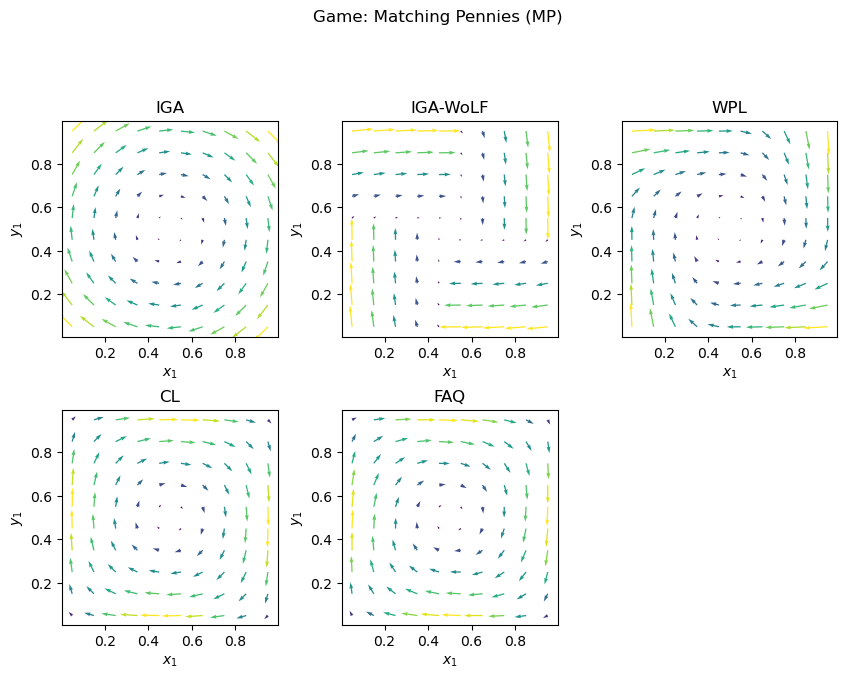

In [23]:
fig = plt.figure(figsize=(10, 7.5))
gs = GridSpec(2, 3, wspace=0.3, hspace=0)
plt.suptitle('Game: Matching Pennies (MP)')

subplotParasDL = [{'title': 'IGA'}, {'title': 'IGA-WoLF'}, {'title': 'WPL'}, {'title': 'CL'}, {'title': 'FAQ'}]
configSubplot(fig, gs, subplotParasDL)

# plot 5 dynamics on MP
fEDL = [IGAdynamics, WoLFdynamics, WPLdynamics, CLdynamics, FAQdynamics]

# Learning Dynamics
ParasDL = [{'alpha': 0.1, 'alpha_min': 0.01, 'alpha_max': 0.1, 'VxStar': 0.5, 'VyStar': 0.5, 'tau': 0.1}] * len(fEDL)
gameNameL = ['MP'] * len(fEDL) # Vx* = Vy* = 0.5

plotVFmain(fig, gameNameL, fEDL, ParasDL)

plt.show()

## Parameter Tuning

**Task 3:** identity a $\tau$ such that the FAQ learning will converge to the Nash Equilibria in the Battle of the Sexes (BS) game, fixing $\alpha=0.1$.

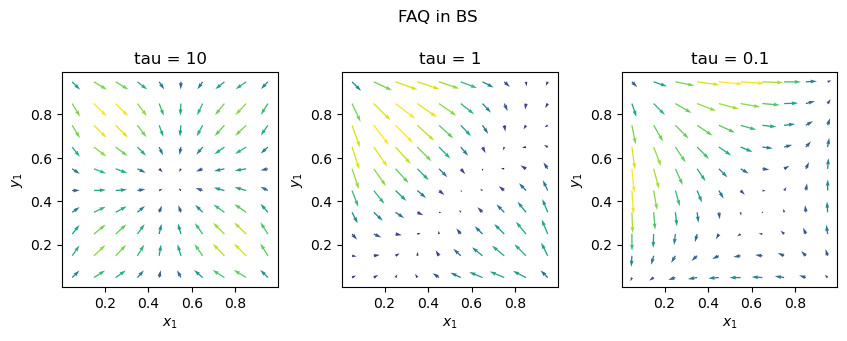

In [24]:
fig = plt.figure(figsize=(10, 3.5))
gs = GridSpec(1, 3, wspace=0.3, hspace=0)
plt.suptitle('FAQ in BS')

##########################################################################
# TODO: try different tau on FAQ
ParasDL = [{'alpha': 0.1, 'tau': 10},
           {'alpha': 0.1, 'tau': 1},
           {'alpha': 0.1, 'tau': 0.1}
          ]


subplotParasDL = [{'title': 'tau = %s'%(ParasD['tau'])} for ParasD in ParasDL]
configSubplot(fig, gs, subplotParasDL)
# Learning Dynamics
gameNameL = ['BS'] * len(ParasDL)
fEDL = [FAQdynamics] * len(ParasDL)

plotVFmain(fig, gameNameL, fEDL, ParasDL)

plt.show()

**Task 4:** identity a $\kappa$ such that the Lenient FAQ learning will converge to action S (action $a_1$) in the Stag Hunt (SH) game, fixing $\alpha=0.1, \tau=0.1$.

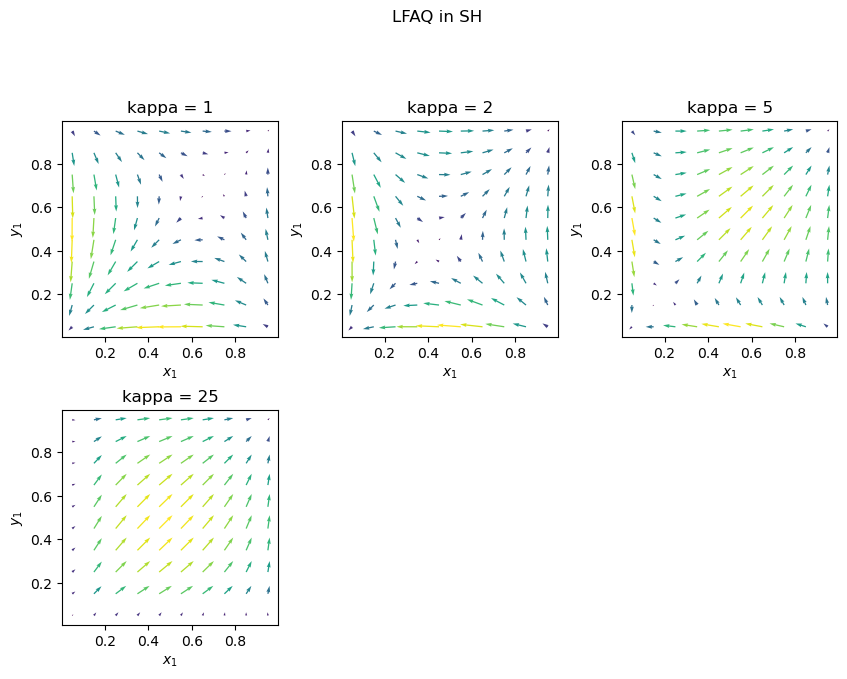

In [25]:
fig = plt.figure(figsize=(10, 7.5))
gs = GridSpec(2, 3, wspace=0.3, hspace=0)
plt.suptitle('LFAQ in SH')

##########################################################################
# TODO: try different kappa on LFAQ
ParasDL = [{'alpha': 0.1, 'tau': 0.1, 'kappa': 1},
           {'alpha': 0.1, 'tau': 0.1, 'kappa': 2},
           {'alpha': 0.1, 'tau': 0.1, 'kappa': 5},
           {'alpha': 0.1, 'tau': 0.1, 'kappa': 25}
          ]


subplotParasDL = [{'title': 'kappa = %s'%(ParasD['kappa'])} for ParasD in ParasDL]
configSubplot(fig, gs, subplotParasDL)
# Learning Dynamics
gameNameL = ['SH'] * len(ParasDL)
fEDL = [LFAQdynamics] * len(ParasDL)



plotVFmain(fig, gameNameL, fEDL, ParasDL)

plt.show()